In [2]:
%pylab inline
from bigbrother.ministry import Ministry
from bigbrother.magnitudemetric import LuminosityFunction, TabulatedLuminosityFunction, AnalyticLuminosityFunction
from bigbrother.massmetric import MassFunction
from bigbrother.lineofsight import DNDz
from bigbrother.healpix_utils import Area
from bigbrother.halo import HaloCatalog
from glob import glob
from collections import OrderedDict
import sys
import healpy as hp
import fitsio
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Compare the Buzzard luminosity function with other LFs

The first thing you usually want to do when using this code is to define a ministry object. Ministry objects contain information about cosmology, survey geometry, and how to optimize the I/O for running various calculations. They are the framework around which different types of catalogs are understood by the code.

In [25]:
bzd = Ministry(0.3, 0.7, 0.7, 0.0, 2.0, 3*53.71)

The goal of this piece of code is to hide the differences between various types of catalogs using different catalog classes which inherit from the same BaseCatalog class. That way, whenever we want to do something with a galaxy catalog, or a halo catalog that action just needs to know about the BaseCatalog API.

In general a ministry object usually needs a few pieces of information:
###Metrics
Metrics are functions which calculate summary statistics on the catalogs generally corresponding to observables that we care about.

In [26]:
bzdmetrics = [LuminosityFunction(bzd)]

We'll start simple and just look at a luminosity function in one redshift bin. The luminosity function metric defaults to using a redshift bin of $0.0\le z < 0.2$.

The second piece of information we need is the location of the relevant files on disk, as well as the types of those files. This information is provided by a dictionary called the filestruct. See below for an example.

In [27]:
files = glob('/Users/Amara/Downloads/Buzzard_v1.1_truth.317.fit.txt')
files[:5]

['/Users/Amara/Downloads/Buzzard_v1.1_truth.317.fit.txt']

In [28]:
g = fitsio.read(files[0])

In [29]:
print(len(g))
print(g.dtype)

4965789
[('ID', '>i8'), ('INDEX', '>i4'), ('ECATID', '>i4'), ('COEFFS', '>f4', (5,)), ('TMAG', '>f4', (5,)), ('OMAG', '>f4', (5,)), ('FLUX', '>f4', (5,)), ('IVAR', '>f4', (5,)), ('OMAGERR', '>f4', (5,)), ('AMAG', '>f4', (5,)), ('RA', '>f4'), ('DEC', '>f4'), ('Z', '>f4'), ('HALOID', '>i4'), ('RHALO', '>f4'), ('M200', '>f4'), ('NGALS', '>i4'), ('R200', '>f4'), ('CENTRAL', '>i2'), ('TRA', '>f4'), ('TDEC', '>f4'), ('EPSILON', '>f4', (2,)), ('GAMMA1', '>f4'), ('GAMMA2', '>f4'), ('KAPPA', '>f4'), ('MU', '>f4'), ('LMAG', '>f4', (5,)), ('MAG_U', '>f4'), ('SIZE', '>f4'), ('SIZE_SUBARU', '>f4'), ('ARBORZ', '>f4'), ('ARBORZ_ERR', '>f4'), ('ANNZ', '>f4'), ('ANNZ_ERR', '>f4'), ('PHOTOZ_GAUSSIAN', '>f4'), ('PX', '>f4'), ('PY', '>f4'), ('PZ', '>f4'), ('VX', '>f4'), ('VY', '>f4'), ('VZ', '>f4'), ('PSTAR', '>f4'), ('PQSO', '>f4'), ('N_SERSIC', '>f4'), ('R50', '>f4'), ('TE', '>f4', (2,)), ('TSIZE', '>f4'), ('W', '>f4')]


In [30]:
bfs = {}
bfs['truth'] = files[:3]

The key of the filestruct specifies the type of file and the value is a list of all the files of that type that we want to use. Here I have designated a number of 'truth' files, but the key could have been anything as long as it is refered to consistently.

In order for the galaxy catalog object that we are about to create to know where to find various pieces of information that it needs in the files we just definied, we should define something called a fieldmap. This is a dictionary whose keys are the fields that are required by the metrics we want to use. These fields are called mapkeys in the code. 

The values of a fieldmap are also dictionaries. This time, the keys are the names of the fields corresponding to mapkeys in a catalog file, and the values are lists telling us in which types of files we can find the keys. In this case, the LuminosityFunction metric requires two mapkeys, luminosity and redshift. Thus we must define a fieldmap with these mapkeys as keys. The corresponding value of the luminosity key tells us that the luminosities are located in the 'AMAG' field of truth files. Likewise, redshifts are located in the 'Z' field of truth files.

In [31]:
bzdmetrics[0].mapkeys

['luminosity', 'redshift']

In [32]:
fm = {'luminosity':OrderedDict([('AMAG',['truth'])]),
      'redshift':OrderedDict([('Z', ['truth'])])}

Now we have all of the information that our GalaxyCatalog object needs. This particular galaxy catalog that we are using now is a 'BCC' (Blind Cosmology Challege) catalog. Thus we set our simulations galaxy catalog using the function below.


In [33]:
bzd.setGalaxyCatalog('BCC', bfs, fieldmap=fm)
bzd.galaxycatalog.metrics = bzdmetrics

In [34]:
bzd.validate()

*****LuminosityFunction*****


Now we can compare this to a the Bernardi 2013 (http://arxiv.org/abs/1304.7778) luminosity function as well as a double Schechter function plus a Gaussian tail at high luminosities.

In [35]:
bf = np.array(['/u/ki/jderose/ki23/amatch/bernardi-test/anc/LF_SerExpAll.dat'])
bern = Ministry(0.286, 0.714, 0.7, 0.0, 2.0, 53.71)
bernLF = TabulatedLuminosityFunction(bern,fname=bf)
bernLF.loadLuminosityFunction()

IOError: /u/ki/jderose/ki23/amatch/bernardi-test/anc/LF_SerExpAll.dat not found.

In [ ]:
p0 = np.array([  1.50528627e-02,  -1.66000000e-01,   6.47466081e-03,  -1.52300000e+00,
  -2.00100000e+01,   2.0e-03,  -2.1500000e+01,   7.500000e-01])
dsgin = Ministry(0.286, 0.714, 0.7, 0.0, 2.0, 53.71)
dsgLF = AnalyticLuminosityFunction(dsgin)
dsgLF.calcNumberDensity(p0, form='doubleSchechterGaussian')

In [ ]:
bzdLF = bzd.galaxycatalog.metrics[0]

In [ ]:
bzdLF.visualize()

In [ ]:
f, ax = bzdLF.compare([bernLF, dsgLF], fylim=[-1.0, 1.0])
f.set_figheight(15)
f.set_figwidth(15)

## Calculating $\frac{dn}{dz}$

In [20]:
bzdmetrics = [Area(bzd, nside=256), DNDz(bzd, magbins=[19], cutband=2, zbins=np.linspace(-0.0125, 0.5125, 22), normed=True)]
print(bzdmetrics[0].mapkeys)
print(bzdmetrics[1].mapkeys)

['polar_ang', 'azim_ang', 'appmag']
['appmag', 'redshift']


In [21]:
fm = {'appmag':OrderedDict([('OMAG',['truth'])]),
      'redshift':OrderedDict([('Z', ['truth'])]),
      'polar_ang':OrderedDict([('DEC', ['truth'])]),
      'azim_ang':OrderedDict([('RA', ['truth'])])}

bzd.setGalaxyCatalog('BCC', bfs, fieldmap=fm)
bzd.metrics = bzdmetrics


In [27]:
bzdmetrics[1].nmagbins

1

In [22]:
bzd.validate(nmap=1)

*****DNDz*****
*****Area*****


bigbrother/galaxy.py:77: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  return self.ministry.metrics[idx].area


(<matplotlib.figure.Figure at 0x10dfcc750>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x10dfcca10>], dtype=object),
 [<matplotlib.lines.Line2D at 0x10df1dfd0>])

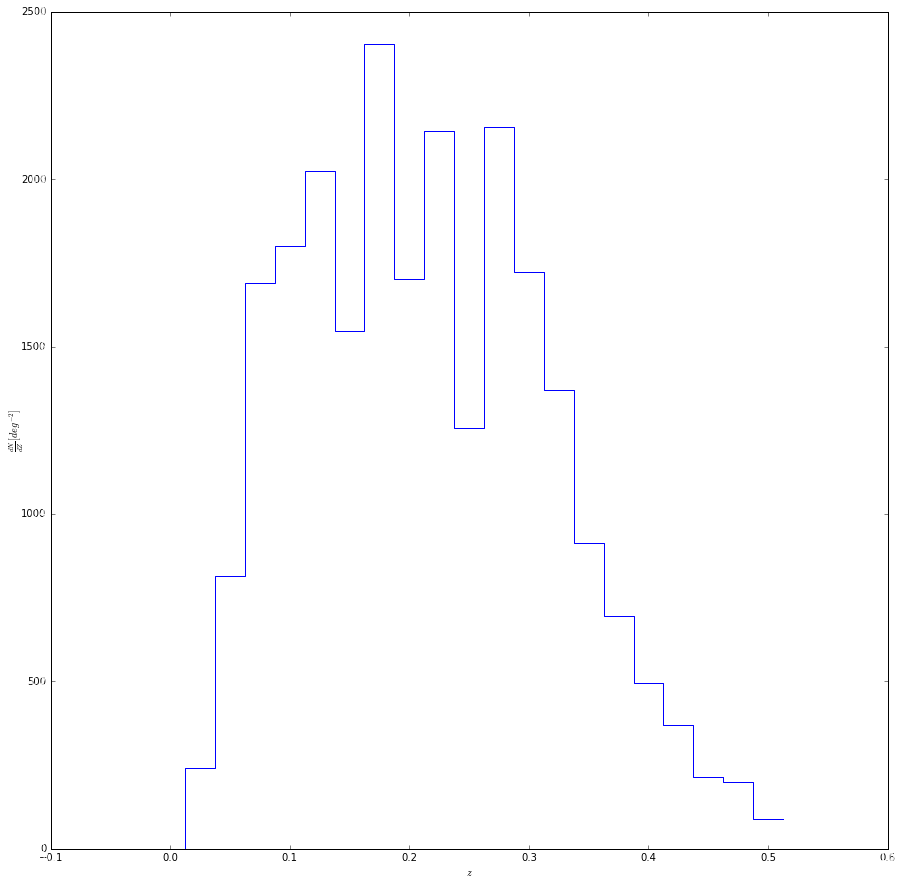

In [23]:
bzd.metrics[1].visualize()

## Plotting the Buzzard halo mass function

In this example we will plot the halo mass function of a BCC style halo catalog. Some halo files can be found as follows.

In [ ]:
hfiles = glob('/u/ki/jderose/desims/addgals/catalogs/Buzzard/Catalog_v1.1/halos/Buzzard_v1.1_halos_rotated.*.fit')
hfiles[:5]

Let's create a file structure for our halo catalog using these files

In [ ]:
hfs = {}
hfs['truth'] = hfiles[:3]

First of all, let's create a mass function object associated with the Buzzard ministry with default settings for mass and redshift bins.

In [ ]:
bzdmfcn = MassFunction(bzd)

Once we have this, we can find out what mapkeys the MassFunction metric requires

In [ ]:
bzdmfcn.mapkeys

We see that we need halo masses and redshifts. We now need to define a new field map for the halo catalog, similar to the one we defined for the galaxy catalog but with these mapkeys instead of luminosity and redshift. Let's look in the halo files to see where we can find mass and redshfit.

In [ ]:
halos = fitsio.read(hfiles[0])
print(halos.dtype)

There is a M200 field, and a Z field. These will work fine for our purposes.

In [ ]:
    hfm = {'mass':OrderedDict([('M200',['truth'])]),
          'redshift':OrderedDict([('Z', ['truth'])])}

In [ ]:
bzd.setHaloCatalog('BCC', hfs, fieldmap=hfm)
bzd.halocatalog.metrics = [bzdmfcn]
#We're resetting the ministry metrics here, because we don't want to recalculate the luminosity function
bzd.metrics = [bzdmfcn]

In [ ]:
bzd.validate()

This mass function will look strange below 3e13 $M_{\odot}$ because it measured on halos of three different resolution boxes.

In [ ]:
bzdmfcn.visualize()

## Rockstar halo catalogs

Here we provide an example of how to create a halo catalog which uses a rockstar catalog reader.

In [7]:
mstry = Ministry(0.3, 0.7, 0.7, 0.0, 2.0, 100)

In [11]:
fs = {}
fs['truth'] = ['/nfs/slac/g/ki/ki18/des/swmclau2/chinchilla1050/out_9.list']
fm = {'mass':OrderedDict([('M200b',['truth'])])}

In [16]:
#Need to provide units for quantities we want to use 
#since we're not using a specialized halo catalog class 
#like BCCHaloCatalog
#here we are telling the code that masses in this catalog are
#in units of m_sun/h (abbreviated msunh for python syntax reasons)
unitmap = {'mass':'msunh'}

In [18]:
hc = HaloCatalog(mstry, fs, fieldmap=fm, reader='rockstar', unitmap=unitmap)
mstry.halocatalog = hc
mstry.metrics = [MassFunction(mstry, lightcone=False)]

In [19]:
mstry.validate()

*****MassFunction*****


In [21]:
hmf = mstry.metrics[0]

/nfs/slac/g/ki/ki21/cosmo/jderose/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/nfs/slac/g/ki/ki21/cosmo/jderose/anaconda/lib/python2.7/site-packages/matplotlib/mathtext.py:860: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


'AxesSubplot' object does not support indexing


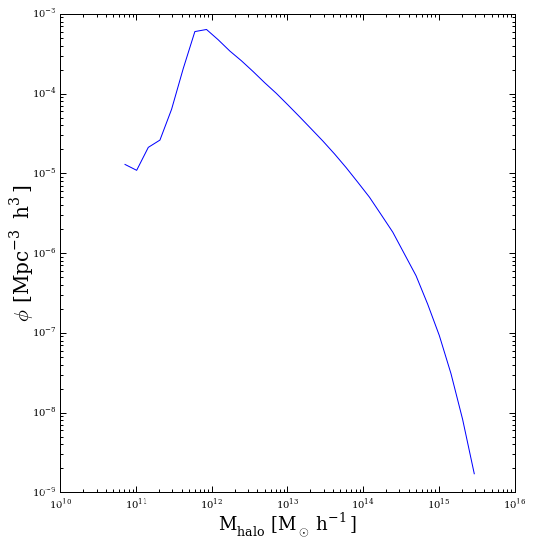

In [22]:
hmf.visualize()